#### Model building setup

Contains:
- DINOv2 frozen backbone loading
- pooling
- extraction of tabular data + images separately
- concatenation
- MLP structure
- (Frozen and unfrozen DINOv2 weights)


In [2]:
import torch

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#dino.eval()


Using cache found in C:\Users\julia/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\julia/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\julia/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\julia/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [3]:
#freeze parameters
for p in dino.parameters():
    p.requires_grad = False


import os
print(os.getcwd())

c:\Users\julia\Documents\Image2Biomass_BME338\scripts


In [5]:
#Pre-process images
from torchvision.transforms import v2
import pandas as pd
import torch
import os
from PIL import Image


def preprocess(img_folder_rel_path,resize):
    transformer = v2.Compose([
        v2.Resize(size=resize),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean = [0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
        ])
    processed_images = []
    image_paths = []
    folder_path = os.path.join(img_folder_rel_path)
    folder_path = folder_path.replace('\\', '/')
    for file in sorted(os.listdir(folder_path)):
        if file.lower().endswith('jpg'):
            img_path = os.path.join(folder_path,file)
            img_path = img_path.replace('\\', '/')
            img = Image.open(img_path).convert('RGB')
            trans_img = transformer(img)
            processed_images.append(trans_img)
            image_paths.append(img_path)
    print('Images processed')
    print(len(processed_images))
    return processed_images, image_paths

processed_images, image_paths = preprocess('../data/train',224)


Images processed
357


In [6]:
#stack the images 
img_batch = torch.stack(processed_images)


In [7]:
with torch.no_grad():  
    outputs = dino(img_batch)

In [8]:
print(outputs.shape)

torch.Size([357, 384])


In [9]:
import umap
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

features = outputs.numpy()

# Persist embeddings for downstream modeling
derived_dir = Path('../data/derived')
derived_dir.mkdir(parents=True, exist_ok=True)
embeddings_df = pd.DataFrame(features)
embeddings_df.insert(0, 'image_path', image_paths)
embeddings_path = derived_dir / 'dino_embeddings.parquet'
embeddings_df.to_parquet(embeddings_path, index=False)
print(f'Saved embeddings to {embeddings_path} with shape {embeddings_df.shape}')

reducer = umap.UMAP()
embedding = reducer.fit_transform(features)
embedding.shape


(357, 2)

Text(0, 0.5, 'UMAP2')

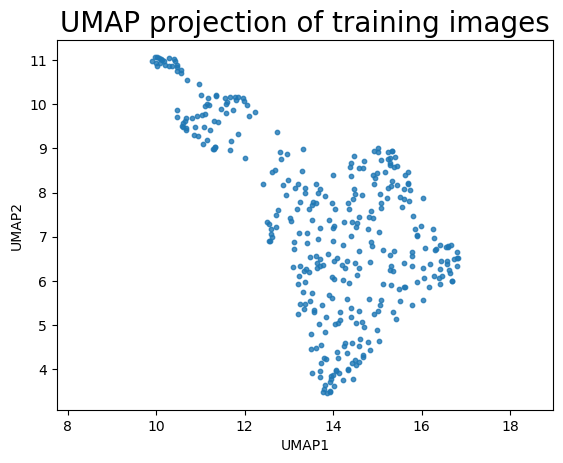

In [10]:
#no classes so we cannot color yet -> add an array to our
#outputs.numpy() which contains the highest target class of each image


plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=10,
    alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of training images', fontsize=20)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

{'Dry_Clover_g': 0, 'Dry_Green_g': 1, 'Dry_Total_g': 2}


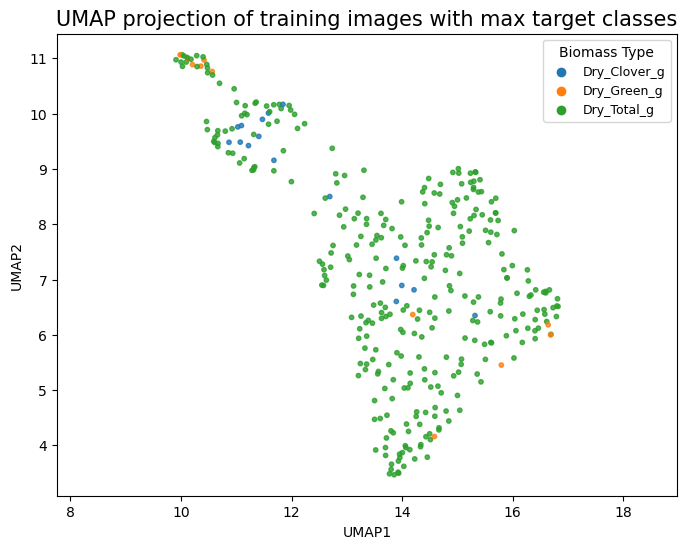

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
tabular_df = pd.read_csv("../data/train.csv")
tabular_df = tabular_df[["image_path","target_name","target"]]
tabular_df.head()


df_highest = tabular_df.loc[tabular_df.groupby("image_path")["target"].idxmax()].reset_index(drop=True)

#print(df_highest)

class_arr = df_highest["target_name"].to_numpy()
unique_classes = np.unique(class_arr)

class_mapping = {}
i = 0
for name in unique_classes:
    class_mapping[name] = i
    i += 1

print(class_mapping)

class_ids = np.array([class_mapping[i] for i in class_arr])
#print(class_ids)
class_ids = class_ids.reshape(-1, 1) #reshape into a column

combined = np.hstack([features,class_ids])
combined.shape #now features from dino + class id as extra column for umap

embedding2 = reducer.fit_transform(combined)
palette = sns.color_palette("tab10", len(unique_classes))

colors = [palette[x] for x in class_ids.squeeze()]

plt.figure(figsize=(8,6))
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=colors,
    s=10,
    alpha=0.8
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of training images with max target classes', fontsize=15)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")

# legend setup
for i, cls in enumerate(unique_classes):
    plt.scatter([], [], color=palette[i], label=cls)

plt.legend(title="Biomass Type", loc="best", fontsize=9)
plt.show()
    

In [ ]:
img_tab_data = pd.read_csv("../data/train.csv")
img_tab_data = img_tab_data[["State","Species","Pre_GSHH_NDVI","Height_Ave_cm"]]

def concat_img_tab_data(img_features, tab_data):
    cols = ["State", "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"]
    img_tab_data_lst = []
    for i in range(0, len(tab_data), 5):
        img_tab_data_lst.append(tab_data.loc[i, cols])
    img_tab_arr = np.array(img_tab_data_lst)
    img_tab_arr = img_tab_arr.reshape(357,4)
    combined_data = np.hstack([img_features, img_tab_arr])
    return combined_data

#complete training data for X in MLP model

concat_img_tab_data(features, img_tab_data)
    

(357, 388)
